# Figure 7: Shannon Entropy Analysis

This notebook generates Figure 7 showing Shannon entropy derived from simulation origin probabilities (SOPs).

Shannon entropy is calculated as:
$$H(\vec{x}) = -\sum_{i}^{n=7} P(sim_{i} | \vec{x}) \, \log_2(P(sim_{i} | \vec{x}))$$

The figure shows entropy distributions across UMAP space for both calculation methods:

1. **Method 1**: Galaxy count weighted approach (`bias=True`)
2. **Method 2**: Equal weighting approach (`bias=False`)

High entropy regions indicate areas where multiple simulations have similar probabilities (high uncertainty), while low entropy regions are dominated by single simulations (high certainty).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from matplotlib.patches import Rectangle
import sys
import pickle
import cmasher as cmr

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing, P_s_x, P_x_s,
                           SM_axis_label, sSFR_axis_label)
from utils.plotting import (draw_battleship_grid, is_dark, draw_grid_C, 
                           plot_points, plot_averages, plot_entropy_contours)

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data and Reconstruct UMAP Structure

In [2]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Reconstructed UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Reconstructed UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


## Create Battleship Grid Structure and Calculate Average SFHs

In [3]:
# Create result array with UMAP coordinates and labels
result = np.column_stack((embedding, combined_labels))

# Create battleship grid structure - divide UMAP space into 10x10 grid
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid (10x10):")
non_empty_cells = 0
for i in range(10):
    for j in range(10):
        if umaps[i,j].shape[0] > 0:
            non_empty_cells += 1
            
print(f"  Non-empty grid cells: {non_empty_cells}/100")

# Calculate average SFH percentiles per grid cell
avg_sfh = boxing(x=embedding[:,0], y=embedding[:,1], z=combined_sfh, q=[16,50,84])

print(f"\nCalculated average SFHs per cell: {type(avg_sfh)} with shape {avg_sfh.shape}")

# Create meshgrid for evaluation
xx, yy = np.mgrid[0:10:100j, 0:10:100j]
pos = np.vstack([xx.ravel(), yy.ravel()])

Created battleship grid (10x10):
  Non-empty grid cells: 69/100

Calculated average SFHs per cell: <class 'numpy.ndarray'> with shape (10, 10, 3, 136)


## Calculate Simulation Origin Probabilities and Shannon Entropy

Shannon entropy quantifies the uncertainty in simulation assignment:
- **Low entropy (≈ 0)**: One simulation dominates (high certainty)
- **High entropy (≈ log₂(7) ≈ 2.8)**: All simulations equally probable (high uncertainty)

In [4]:
def calculate_shannon_entropy(p_s_x, sim_name):
    """
    Calculate Shannon entropy from simulation origin probabilities.
    
    Parameters
    ----------
    p_s_x : dict
        Dictionary of SOPs for each simulation
    sim_name : list
        List of simulation names
        
    Returns
    -------
    entropy : numpy.ndarray
        Shannon entropy values (100x100 grid)
    """
    # Stack probabilities
    p_stack = np.array([p_s_x[sim] for sim in sim_name])
    p_stack = np.nan_to_num(p_stack, nan=0.0)
    
    # Ensure probabilities sum to 1 (normalize)
    p_sum = np.sum(p_stack, axis=0)
    p_stack = np.divide(p_stack, p_sum, out=np.zeros_like(p_stack), where=p_sum!=0)
    
    # Calculate Shannon entropy: H = -Σ p*log2(p)
    # Use small epsilon to avoid log(0)
    epsilon = 1e-10
    p_stack_safe = np.maximum(p_stack, epsilon)
    
    entropy = -np.sum(p_stack * np.log2(p_stack_safe), axis=0)
    
    # Reshape to 100x100 grid
    entropy = entropy.reshape(100, 100)
    
    return entropy

In [5]:
# Method 1: Galaxy count weighted approach (bias=True, normint=False)
print("Calculating SOPs - Method 1 (Galaxy count weighting):")
p_s_x = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
              normint=False, bias=True, mask=False)

# Calculate Shannon entropy from SOPs
entropy = calculate_shannon_entropy(p_s_x, sim_name)
entropy = np.where(entropy <= 0., np.nan, entropy)

print(f"Shannon entropy calculated - shape: {entropy.shape}")
print(f"Entropy range: {np.min(entropy):.3f} to {np.max(entropy):.3f} (max possible: {np.log2(7):.3f})")

Calculating SOPs - Method 1 (Galaxy count weighting):
Shannon entropy calculated - shape: (100, 100)
Entropy range: nan to nan (max possible: 2.807)


In [6]:
from scipy.interpolate import RegularGridInterpolator

# Create 2D interpolator for entropy over the grid
entropy_interp = RegularGridInterpolator((xx[:, 0], yy[0, :]), entropy, 
                                        bounds_error=False, fill_value=np.nan)

# Evaluate entropy at individual galaxy positions
entropy_eval = entropy_interp(embedding)

# Calculate entropy averages per grid cell
entropy_avg = boxing(x=embedding[:,0], y=embedding[:,1], z=entropy_eval, average=True)

print(f"Entropy cell averages calculated - shape: {entropy_avg.shape}")
print(f"Cell average entropy range: {np.nanmin(entropy_avg):.3f} to {np.nanmax(entropy_avg):.3f}")

Entropy cell averages calculated - shape: (10, 10)
Cell average entropy range: 1.208 to 2.574


d:\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)


## Generate Figure 7: Shannon Entropy (Method 1)

Create multi-panel figure showing entropy distributions across UMAP space.

C:\Users\joshs\AppData\Local\Temp\ipykernel_45228\3143710097.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


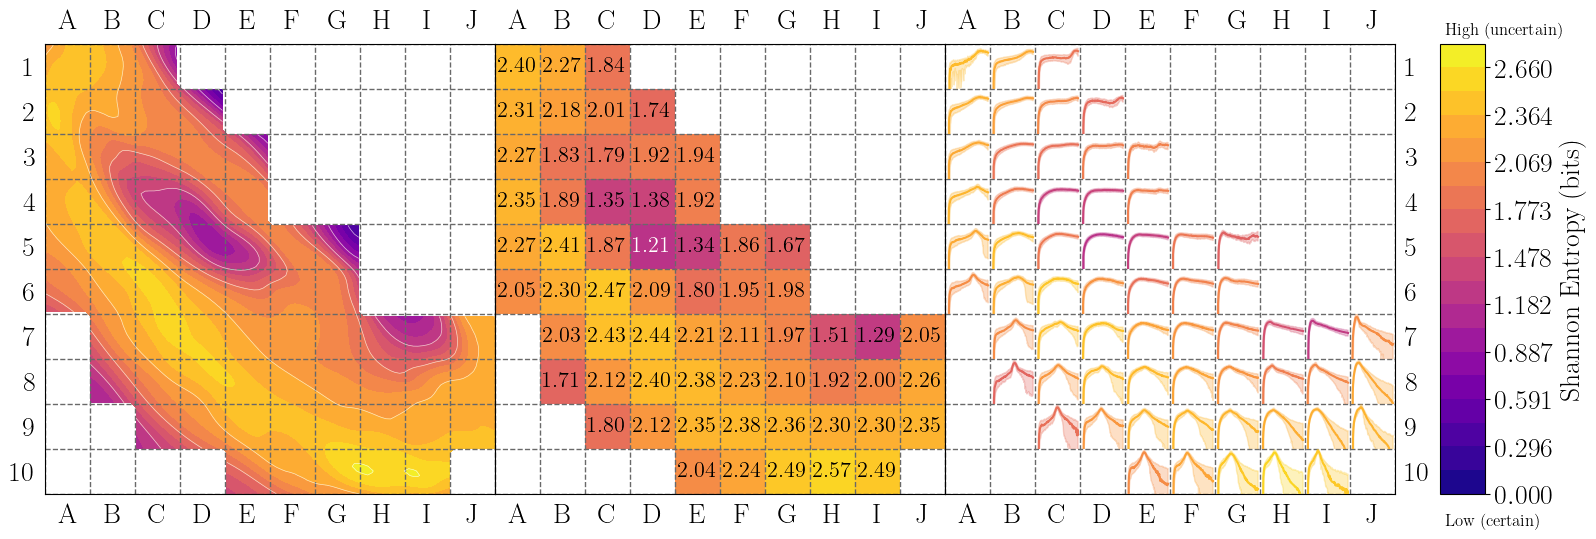

Figure 7 (Weighted Shannon Entropy) generated successfully!


In [7]:
# Generate Figure 7: Shannon Entropy (Method 1)
# Using standard grid layout with entropy visualization
from matplotlib import cm

# Use draw_grid_C for consistent layout (no colormap needed for entropy)
cmap = cm.plasma
fig, ax, norm = draw_grid_C(cmap=cmap, vmin=0, vmax=np.log2(7))

# Plot 1: Entropy contour plot
plot_entropy_contours(entropy.T, fig, ax[0], cax=ax[-1], cmap=cmap, 
                      label='Shannon Entropy (bits)')

# Plots 2-3: Average SFHs using standard function
plot_averages(avg=entropy_avg, avg_sfh=avg_sfh, fig=fig, ax1=ax[1], ax2=ax[2], 
              umaps=umaps, cmap=cmap, norm=norm)

plt.tight_layout()

# Save figure
plt.savefig('../figures/shannon_entropy_weighted.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/shannon_entropy_weighted.pdf', bbox_inches='tight')

plt.show()

print("Figure 7 (Weighted Shannon Entropy) generated successfully!")

In [8]:
# Method 2: Equal weighting approach (bias=False, normint=False)
print("Calculating SOPs - Method 2 (Equal weighting):")
p_s_x2 = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
               normint=False, bias=False, mask=False)

# Calculate Shannon entropy from SOPs (Method 2)
entropy2 = calculate_shannon_entropy(p_s_x2, sim_name)
entropy2 = np.where(entropy2 <= 0., np.nan, entropy2)

print(f"Shannon entropy (Method 2) calculated - shape: {entropy2.shape}")
print(f"Entropy range: {np.min(entropy2):.3f} to {np.max(entropy2):.3f} (max possible: {np.log2(7):.3f})")

Calculating SOPs - Method 2 (Equal weighting):
Shannon entropy (Method 2) calculated - shape: (100, 100)
Entropy range: nan to nan (max possible: 2.807)


In [9]:
# Create 2D interpolator for entropy over the grid (Method 2)
entropy2_interp = RegularGridInterpolator((xx[:, 0], yy[0, :]), entropy2, 
                                         bounds_error=False, fill_value=np.nan)

# Evaluate entropy at individual galaxy positions
entropy2_eval = entropy2_interp(embedding)

# Calculate entropy averages per grid cell
entropy2_avg = boxing(x=embedding[:,0], y=embedding[:,1], z=entropy2_eval, average=True)

print(f"Entropy cell averages (Method 2) calculated - shape: {entropy2_avg.shape}")
print(f"Cell average entropy range: {np.nanmin(entropy2_avg):.3f} to {np.nanmax(entropy2_avg):.3f}")

Entropy cell averages (Method 2) calculated - shape: (10, 10)
Cell average entropy range: 1.668 to 2.634


d:\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:101: RuntimeWarning: Mean of empty slice
  box = np.nanmean(box, axis=0)


C:\Users\joshs\AppData\Local\Temp\ipykernel_45228\1224077769.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


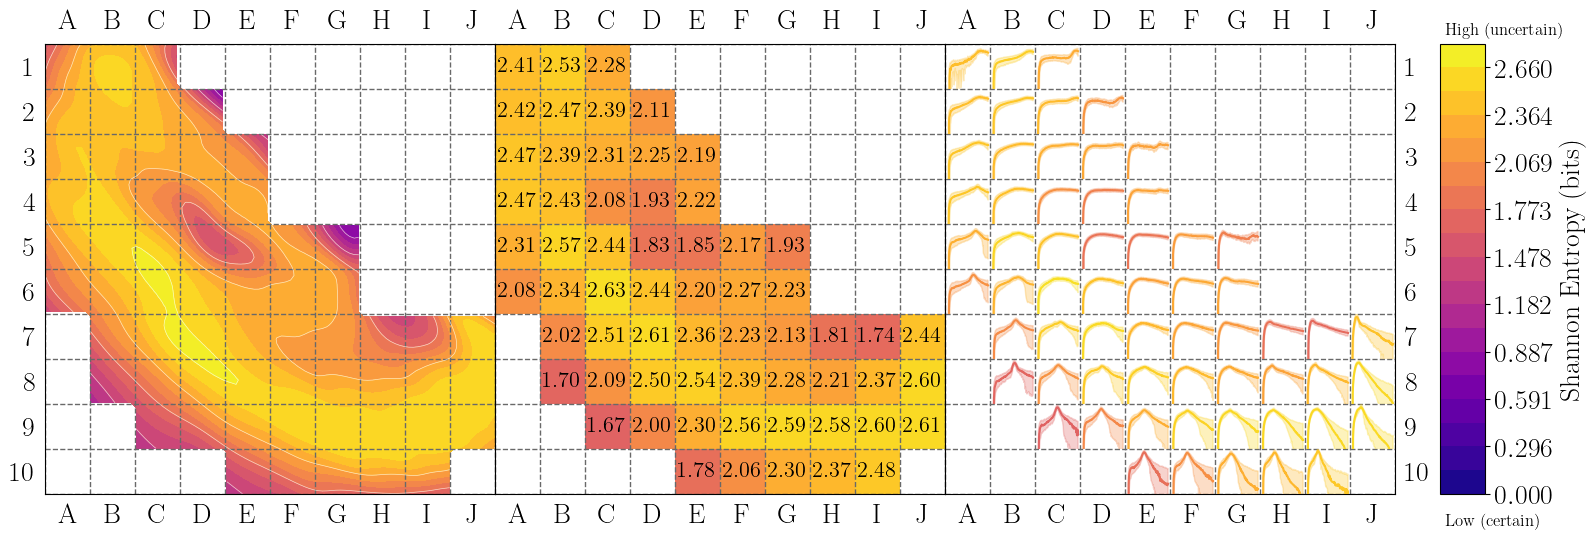

Figure 7 (Uniform Shannon Entropy) generated successfully!


In [10]:
# Generate Figure 7: Shannon Entropy (Method 2)
# Using standard grid layout with entropy visualization
from matplotlib import cm

# Use draw_grid_C for consistent layout (no colormap needed for entropy)
cmap = cm.plasma
fig, ax, norm = draw_grid_C(cmap=cmap, vmin=0, vmax=np.log2(7))

# Plot 1: Entropy contour plot
plot_entropy_contours(entropy2.T, fig, ax[0], cax=ax[-1], cmap=cmap, 
                      label='Shannon Entropy (bits)')

# Plots 2-3: Average SFHs using standard function
plot_averages(avg=entropy2_avg, avg_sfh=avg_sfh, fig=fig, ax1=ax[1], ax2=ax[2], 
              umaps=umaps, cmap=cmap, norm=norm)

plt.tight_layout()

# Save figure
plt.savefig('../figures/shannon_entropy_uniform.png', bbox_inches='tight', dpi=300)
plt.savefig('../figures/shannon_entropy_uniform.pdf', bbox_inches='tight')

plt.show()

print("Figure 7 (Uniform Shannon Entropy) generated successfully!")